In [2]:
import os

In [3]:
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [4]:
model="deepseek-r1-distill-llama-70b"

In [5]:
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

In [6]:
# llm = ChatGroq(model=model)
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro")

In [7]:
llm.invoke("Who is the current president of usa?").content

'The current president of the United States is **Joe Biden**.\n\nHe is the 46th president and assumed office on January 20, 2021.'

In [8]:
import operator
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from typing import TypedDict , Annotated , Sequence , List
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, MessagesState,START,END
from pydantic import BaseModel , Field
from langgraph.prebuilt import ToolNode

In [9]:
def call_model(state:MessagesState):
    message=state['messages']
    # message = HumanMessage(message)
    print(f"current message: {message} ")
    response=llm.invoke(message)
    return {"messages":[response]}

In [10]:
call_model({"messages":["Who are you?"]})

current message: ['Who are you?'] 


{'messages': [AIMessage(content='I am a large language model, trained by Google.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []}, id='run--6f465e83-3e45-4008-8fe1-b2eebaa1f70e-0', usage_metadata={'input_tokens': 5, 'output_tokens': 11, 'total_tokens': 956, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 940}})]}

In [11]:
workflow=StateGraph(
    MessagesState
)

In [12]:
workflow.add_node(
    "call_model",
    call_model,
)

In [13]:
workflow.add_edge(
    START,
    "call_model",
)

In [14]:
workflow.add_edge(
    "call_model",
    END
)

In [15]:
app=workflow.compile()

In [16]:
app.invoke({"messages":["Who made you?"]})['messages'][-1].content

current message: [HumanMessage(content='Who made you?', additional_kwargs={}, response_metadata={}, id='79e44238-5e09-46b1-a3f2-ea76157f4d08')] 


'I am a large language model, trained by Google.'

In [17]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, ToolMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode

# --- 1. Setup ---
# Make sure your environment variables are loaded
# load_dotenv() 
# os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

# --- 2. Define LLMs and Tools ---

# The primary LLM for general conversation
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro")

# Define the custom tool
@tool
def search(query: str):
    """Searches for the current temperature in Delhi, India."""
    if "delhi" in query.lower():
        return "The temperature in Delhi is 30 degrees Celsius."
    else:
        return "Sorry, I can only find the temperature for Delhi."

# The list of tools for the tool-using agent
tools = [search]

# Bind the tools to a new LLM instance to create a "tool-enabled" LLM
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools)


# --- 3. Define Agent Nodes ---

# This node handles general conversation
def general_agent_node(state: MessagesState):
    """Node for answering general questions without tools."""
    response = llm.invoke(state['messages'])
    return {"messages": [response]}

# This node decides if a tool should be used and summarizes the result
def tool_agent_node(state: MessagesState):
    """Node that uses the tool-bound LLM."""
    response = llm_with_tools.invoke(state['messages'])
    return {"messages": [response]}


# --- 4. Define Routers (The Logic for the Graph) ---

def route_message(state: MessagesState):
    """
    The main router. It checks the latest message for keywords to decide
    if the query should go to the tool agent or the general agent.
    """
    message = state['messages'][-1]
    content = message.content.lower()
    
    # Keywords that trigger the tool path
    if "temperature" in content or "weather" in content or "delhi" in content:
        return "tool_path"
    else:
        return "general_path"

def tool_call_router(state: MessagesState):
    """
    After the tool agent runs, this router checks if the LLM
    decided to call a tool.
    """
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        # If the LLM made a tool call, send it to the tool node to be executed
        return "call_tool"
    else:
        # If no tool was called, the LLM has already answered, so we can end.
        return "end_conversation"

# --- 5. Build the Graph ---

workflow = StateGraph(MessagesState)

# Add the nodes to the graph
workflow.add_node("general_agent", general_agent_node)
workflow.add_node("tool_agent", tool_agent_node)
workflow.add_node("tool_executor", tool_node)

# The entry point is our main router
workflow.set_conditional_entry_point(
    route_message,
    {
        "general_path": "general_agent",
        "tool_path": "tool_agent",
    }
)

# Define the connections (edges)
workflow.add_edge("general_agent", END)

workflow.add_conditional_edges(
    "tool_agent",
    tool_call_router,
    {
        "call_tool": "tool_executor",
        "end_conversation": END
    }
)

# After the tool is executed, the result is sent back to the tool_agent
# so it can generate a final, natural language response.
workflow.add_edge("tool_executor", "tool_agent")


# Compile the graph into a runnable app
app = workflow.compile()

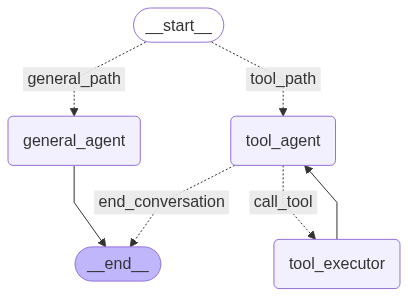

In [18]:
app

In [19]:
app.invoke({"messages": ["What is the temperature in Delhi?"]})['messages'][-1].content

'The temperature in Delhi is 30 degrees Celsius.'